In [28]:
import os
from tqdm import tqdm
import pickle
import random

import pandas as pd
import numpy as np
import scipy
from scipy import ndimage
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt

from metaspace import SMInstance
from anndata import AnnData
from metaspace2anndata import dataset_to_anndata
import scanpy as sc
import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Coloc from AnnData

In [2]:
adata = pickle.load(open(os.path.join('/g/alexandr/tim/metaspace_evaluation/230201/all_ionimages', '2022-12-07_02h13m50s.pickle'), "rb" ) )

In [3]:
adata

AnnData object with n_obs × n_vars = 6216 × 293
    obs: 'x', 'y'
    var: 'formula', 'adduct', 'ionFormula', 'ion', 'mz', 'msm', 'rhoSpatial', 'rhoSpectral', 'moc', 'fdr', 'offSample', 'isotopeImages', 'colocCoeff', 'moleculeNames', 'moleculeIds', 'intensity'
    uns: 'spatial', 'metaspace_metadata', 'metaspace_id', 'metaspace_database_details', 'metaspace_config', 'metaspace_name', 'metaspace_adducts', 'metaspace_databases', 'metaspace_group', 'metaspace_polarity', 'metaspace_principal_investigator', 'metaspace_projects', 'metaspace_status', 'metaspace_submitter'
    obsm: 'spatial'

In [14]:
adata.X.transpose().shape

(293, 6216)

In [26]:
adata.obs

,x,y
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
6211,79,73
6212,80,73
6213,81,73
6214,82,73


In [60]:
adata.X.shape

(6216, 293)

In [58]:
adata.X.sum(axis=0).shape

(293,)

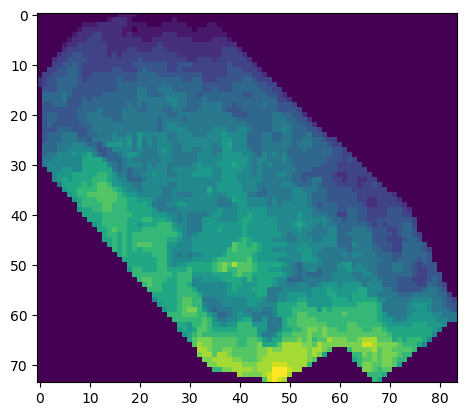

In [83]:
# Potentialy bring intensities to same range
conv = (adata.X/adata.X.sum(axis=0))*1e4

tmp = conv.transpose()
tmp = tmp.reshape((tmp.shape[0], adata.obs['y'].max()+1, -1))
tmp2 = ndimage.median_filter(tmp, size=(1,3,3))

c = 15
plt.imshow(tmp2[c])

(293, 6216)


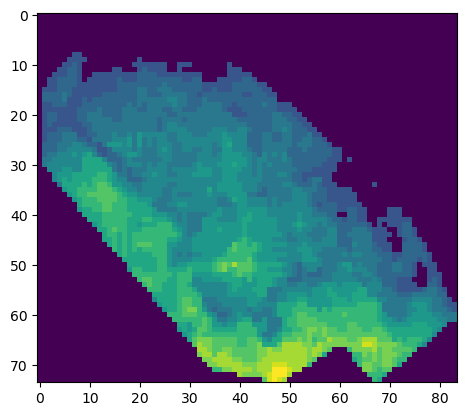

In [84]:
tmp3 = tmp2.reshape((tmp2.shape[0], -1))
print(tmp3.shape)
mask = tmp3 < np.percentile(tmp3, q=50, axis=1)[:, np.newaxis]

tmp3[mask] = 0

tmp_t = tmp3.reshape((tmp.shape[0], adata.obs['y'].max()+1, -1))
plt.imshow(tmp_t[c])

In [85]:
def coloc_preprocessing(adata, scaling=True):
    if scaling:
        conv = (adata.X/adata.X.sum(axis=0))*1e4
    else:
        conv = adata.X
    
    tmp = conv.transpose()
    tmp = tmp.reshape((tmp.shape[0], adata.obs['y'].max()+1, -1))
    tmp2 = ndimage.median_filter(tmp, size=(1,3,3))
    
    tmp3 = tmp2.reshape((tmp2.shape[0], -1))
    mask = tmp3 < np.percentile(tmp3, q=50, axis=1)[:, np.newaxis]
    tmp3[mask] = 0
    
    return tmp3

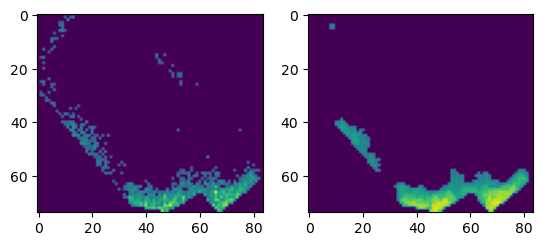

In [94]:
conv_data = coloc_preprocessing(adata)

fig, (ax1, ax2) = plt.subplots(ncols=2)

c = 260

ax1.imshow(adata.X.transpose().reshape((adata.X.shape[1], adata.obs['y'].max()+1, -1))[c])
ax2.imshow(conv_data.reshape((adata.X.shape[1], adata.obs['y'].max()+1, -1))[c])

## ASMS poster plots

In [97]:
from config import date_key, data_dir, store_dir
import utils

In [98]:
dss = pickle.load(open(os.path.join(store_dir, 'all_datasets.pickle'), "rb" ) )
results = pickle.load(open(os.path.join(store_dir, 'hmdb4_results.pickle'), "rb" ) )
md = utils.make_metadata_dict(dss, results)
mdt = utils.clean_metadata_table(utils.metadata_dict_totable(md))

/home/trose/projects/metaspace_evaluation/utils.py:70: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  convert_dict[key] = pd.Series(md[key])
/home/trose/projects/metaspace_evaluation/utils.py:70: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  convert_dict[key] = pd.Series(md[key])


#### Metadata stats plots

In [114]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

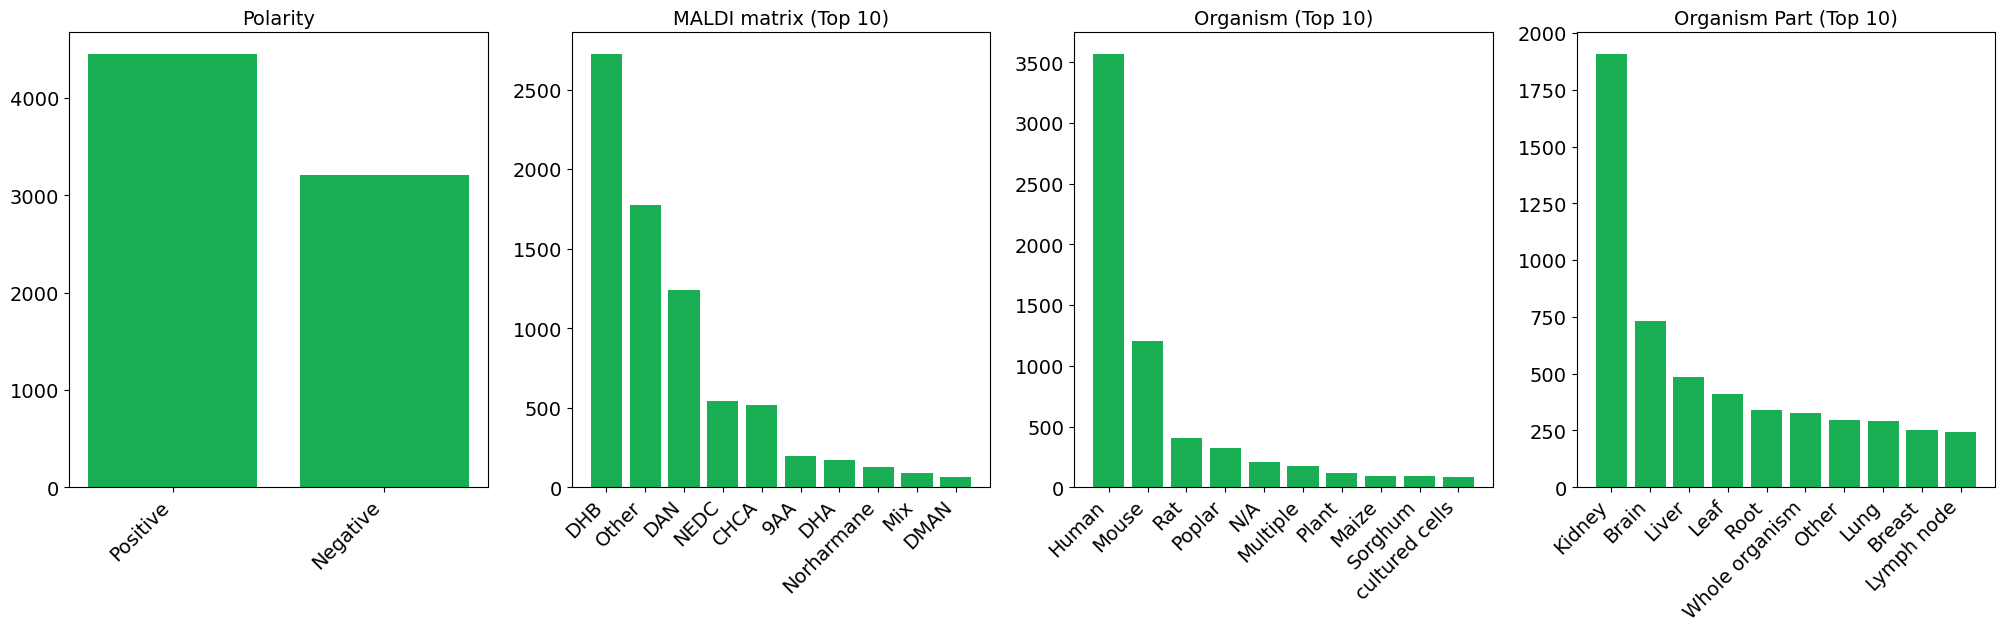

In [115]:
cm = 1/2.54
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(63.130*cm, 15*cm))

col = 'Polarity'
tmp = pd.value_counts(mdt[col])[0:20]
ax1.bar(range(len(tmp)), list(tmp.values), align='center', color='#1aae54')
ax1.set_xticks(range(len(tmp)), list(tmp.index), rotation = 45, ha='right')
ax1.set_title('Polarity')

col = 'maldi_matrix'
tmp = pd.value_counts(mdt[col])[0:10]
ax2.bar(range(len(tmp)), list(tmp.values), align='center', color='#1aae54')
ax2.set_xticks(range(len(tmp)), list(tmp.index), rotation = 45, ha='right')
ax2.set_title('MALDI matrix (Top 10)')

col = 'Organism'
tmp = pd.value_counts(mdt[col])[0:10]
ax3.bar(range(len(tmp)), list(tmp.values), align='center', color='#1aae54')
ax3.set_xticks(range(len(tmp)), list(tmp.index), rotation = 45, ha='right')
ax3.set_title('Organism (Top 10)')

col = 'Organism_Part'
tmp = pd.value_counts(mdt[col])[0:10]
ax4.bar(range(len(tmp)), list(tmp.values), align='center', color='#1aae54')
ax4.set_xticks(range(len(tmp)), list(tmp.index), rotation = 45, ha='right')
ax4.set_title('Organism Part (Top 10)')

plt.savefig("plots/metadata_stats.pdf", dpi=300)

In [119]:
def apd(results, fdr_cutoff=0.05):
    n_anno = []
    for tab in results.values():
        if tab[tab['fdr'] <= fdr_cutoff].shape[0] >0:
            n_anno.append(tab[tab['fdr'] <= fdr_cutoff].shape[0])
            
    return n_anno

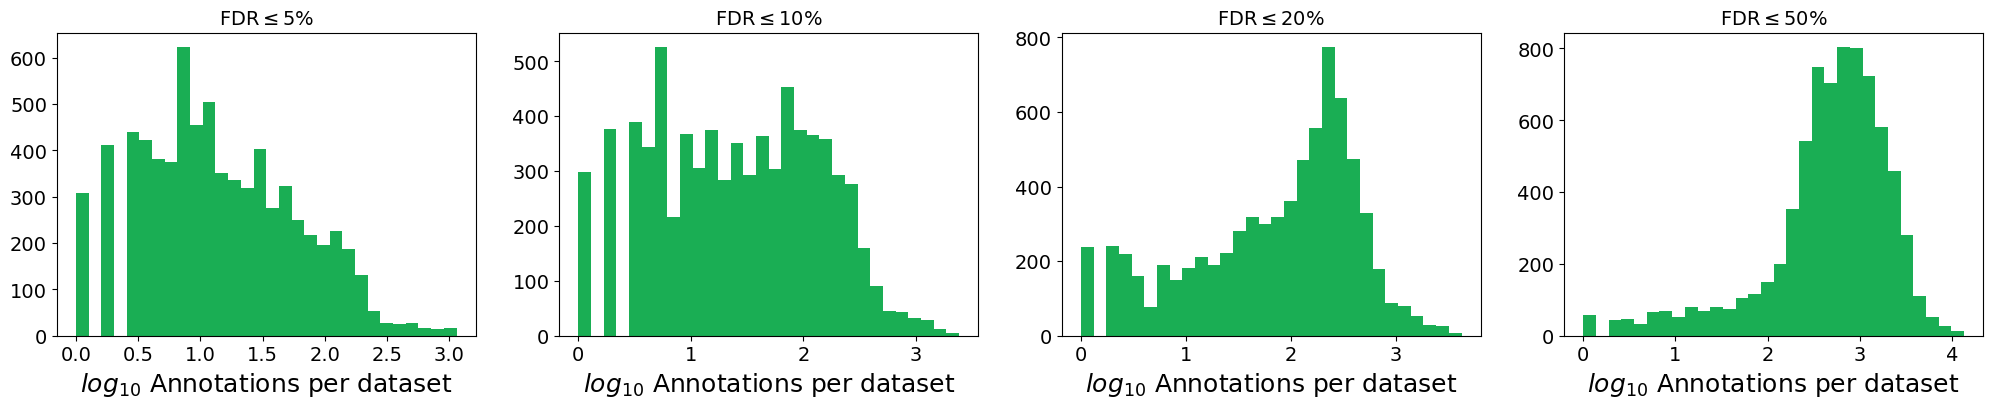

In [122]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(63.130*cm, 10*cm))

ax1.hist(np.log10(apd(results, 0.05)), bins=30, color='#1aae54')
ax1.set_title(r"FDR$\leq$5%")
ax1.set_xlabel(r'$log_{10}$ Annotations per dataset')
         
ax2.hist(np.log10(apd(results, 0.1)), bins=30, color='#1aae54')
ax2.set_title(r"FDR$\leq$10%")
ax2.set_xlabel(r'$log_{10}$ Annotations per dataset')

ax3.hist(np.log10(apd(results, 0.2)), bins=30, color='#1aae54')
ax3.set_title(r"FDR$\leq$20%")
ax3.set_xlabel(r'$log_{10}$ Annotations per dataset')
         
ax4.hist(np.log10(apd(results, 0.5)), bins=30, color='#1aae54')
ax4.set_title(r"FDR$\leq$50%")
ax4.set_xlabel(r'$log_{10}$ Annotations per dataset')

plt.savefig("plots/annotation_stats.pdf", dpi=300)